# mimicking face pareidolia

In this project, I want to train/find a computer vision algorithm, that is able to mimick the face paredolia behaviour of some subjects using computer vision techniques.

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
np.random.seed(42)
from PIL import Image # to handle images
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import ttest_ind
from keras.models import Sequential
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


Using TensorFlow backend.


## functions to process train images

### iteratively binarize images until there is a approximately 50:50 distribution of black and white pixels

- then: add the same image as inverted for augmentation

In [2]:
def iter_binarize(imgArr): # input: an image array of format X,Y,1 (non-color)
    # find median value as threshold
    #plt.imshow(testImg); plt.show()
    threshold = np.median(imgArr)
    imgArr = cv2.threshold(imgArr,threshold,255,cv2.THRESH_BINARY)
    #imgArr = imgArr[1].astype("int32")
    #plt.imshow(testImgB); plt.show()
    return imgArr

### for celeb database

In [3]:
# load images and process to the format
def load_and_preproc(file, crop = False):
    img = cv2.imread(file,0)
    if crop:
        img = img[50:168, 40:140].copy() # crop, original shape: 218x178
    img = cv2.resize(img,(32,43)) # reshape it
    img = iter_binarize(img)    # put in here the iter_hinarize
    #print(img[1].shape)
    img = cv2.cvtColor(img[1],cv2.COLOR_GRAY2RGB) # to rgb #np.float32(
    #img = np.expand_dims(img, 0) # new dimension
    return img

def augment_image(images4D):
    ori_length = images4D.shape[0]
    images4DAug = np.concatenate( (images4D, images4D, images4D, images4D), axis = 0 ) # quadruple it
    images4DAug[ori_length*2:,:,:,:] = 255 - images4DAug[ori_length*2:,:,:,:] #invert the last half
    images4DAug[ori_length:ori_length*2,:,:,:] = np.flip(images4DAug[ori_length:ori_length*2,:,:,:], axis = 2) # flip the second quarter
    images4DAug[ori_length*3:ori_length*4,:,:,:] = np.flip(images4DAug[ori_length*3:ori_length*4,:,:,:], axis = 2)# flip the fourth quarter
    return images4DAug
    
def render_noisy(images4D, p=0.2):
    na,nb,nc,nd = images4D.shape
    for a in range(na):
        for b in range(nb):
            for c in range(nc):
                r = np.random.binomial(1,p)
                if r == 1:
                    images4D[a,b,c,0] = 255-images4D[a,b,c,0]
                    images4D[a,b,c,1] = 255-images4D[a,b,c,1]
                    images4D[a,b,c,2] = 255-images4D[a,b,c,2]
    return images4D

In [4]:
np.random.binomial(1,0.2)

0

### for tiny-imagenet images

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes') # bytes
    return dict

# load images and process to the format
def preproc(img): # input image is an 3D Array (X*Y*3colors)
    #img = data_flowers[i,:,:,:]
    img = cv2.resize(img,(32,43))
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # put in here the iter_hinarize
    
    img = cv2.cvtColor(np.float32(img),cv2.COLOR_GRAY2RGB)
    data_flowers_res[i,:,:,:] = img
    return img

## construct and compile a model for transfer learning

In [6]:
def transfer_learning():
    # get mobilenet and add some layers at the end, 2 output classes
    model = Sequential()
    model.add(MobileNet(weights='imagenet',include_top=False, input_shape = (43, 32, 3) )) #imports the mobilenet model and discards the last 1000 neuron layer.
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(2, activation='softmax')) # sigmoid
    #model.summary()
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # adam
    return model

## test labeled noise-images with the trained model

In [7]:
def predictions_noise(model, X_test):
    predictions = model.predict_proba(X_test)
    facePredictions = predictions[:,1]
    plt.plot(facePredictions)
    plt.show()

In [8]:
def load_labels_and_stim(s, sigma = 1): # s: subject identifier
    # load behavior file
    behaviorFile = 'D:/paredolia/facepareidolia/labels/' + s + 'df.csv'
    df = pd.read_csv(behaviorFile)

    # load stimuli

    files = sorted(glob('D:/paredolia/facepareidolia/stimuli/'+ s +'/' + '*.tif'))

    X = np.ndarray((len(files),43,32,3))
    yn = []
    c = 0
    for j, file in enumerate(files):
        fname = os.path.split(os.path.normpath(file))[-1] # file name without path

        # check if face or noface
        try:
            if df.loc[df['picture'] == fname, 'category'].iloc[0] == "Face":
                yn.append(1)
            elif df.loc[df['picture'] == fname, 'category'].iloc[0] == "noFace":
                yn.append(0)
        except:
            #print(fname  + "not rated !")
            c += 1
            continue
        img = cv2.imread(file,0)
        img = cv2.resize(img,(32,43)) # reshape it
        img = np.flip(img, axis = 0) # faces are upside down
        img = cv2.GaussianBlur(img,(sigma,sigma),0)
        img = cv2.threshold(img,127,255,cv2.THRESH_BINARY) #TTT
        img = cv2.cvtColor(img[1],cv2.COLOR_GRAY2RGB) # to rgb
        img = np.expand_dims(img, 0) # new dimension
        X[j-c,:,:,:] = img.astype("int32")
    X = np.delete(X, list(range(X.shape[0]-c , X.shape[0])), axis = 0) # delete the images which were not rated
    return X, yn

def test_model(model, sigma = 1):
    
    # determine subjects
    subs = glob("D:/paredolia/facepareidolia/stimuli/*")
    subs = [os.path.split(subs[i])[1] for i,s in enumerate(subs)]
    
    # loop over subjects
    allFacePrediction = np.ndarray(1)
    allNoFacePrediction = np.ndarray(1)
    for i,s in enumerate(subs):
        #print('subject ' + s)
        
        # load stimuli and labels
        X, yn = load_labels_and_stim(s, sigma = sigma)
        
        # predict
        predictions = model.predict_proba(X)
        facePredictions = predictions[:,1]
        #plt.plot(facePredictions)
        #plt.show()
        indices_face   = [i for i, x in enumerate(yn) if x == 1]
        indices_noface = [i for i, x in enumerate(yn) if x == 0]
        
        # test significance
        print(ttest_ind(facePredictions[indices_face], facePredictions[indices_noface], equal_var=True))
        allFacePrediction = np.concatenate([allFacePrediction,facePredictions[indices_face]],axis=0)
        allNoFacePrediction = np.concatenate([allNoFacePrediction,facePredictions[indices_noface]],axis=0)
        # test significance for the 100 strongest images
        
    # test significance across subjects !!
    print("across all subjects:")
    print(ttest_ind(allFacePrediction, allNoFacePrediction, equal_var=True))
    
def compare_prediction_similarities(model, sigma = 1):
    
    # determine subjects
    subs = glob("D:/paredolia/facepareidolia/stimuli/*")
    subs = [os.path.split(subs[i])[1] for i,s in enumerate(subs)]
    
    # loop over subjects
    predAllSub = []
    labelAllSub = []
    for i,s in enumerate(subs):
        print('subject ' + s)
        
        # load stimuli and labels
        X, yn = load_labels_and_stim(s, sigma = sigma)
        
        # predict
        predictions = model.predict_proba(X)
        facePredictions = predictions[:,1]
        
        predAllSub.append(facePredictions)
        labelAllSub.append(yn)
        
    return predAllSub, labelAllSub
        

In [11]:
subs = glob("D:/paredolia/facepareidolia/stimuli/*")
subs = [os.path.split(subs[i])[1] for i,s in enumerate(subs)]
yAll = []
for s in subs:
    _, y1 = load_labels_and_stim(s, sigma = 1)
    yAll.append(y1)
yAll


[[1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,


In [12]:
proportions = [sum(y) / len(y) for y in yAll]
proportions

[0.2858877086494689,
 0.26344247521778313,
 0.33400402414486924,
 0.42542542542542544,
 0.3034274193548387,
 0.467935871743487,
 0.36436436436436437,
 0.4073319755600815,
 0.4177732379979571,
 0.26545086119554206,
 0.3534136546184739,
 0.45545545545545546]

In [15]:
min(proportions)

0.26344247521778313

In [16]:
max(proportions)

0.467935871743487

### create internal templates of faces

In [334]:
def internal_template(model, gauss = 0, sigma = 1):
    from scipy.ndimage.filters import gaussian_filter
    # determine subjects
    subs = glob("D:/paredolia/facepareidolia/stimuli/*")
    subs = [os.path.split(subs[i])[1] for i,s in enumerate(subs)]
    
    fig, ax = plt.subplots(nrows=2,ncols=12, figsize = (20,5))
    # loop over subjects
    for j,s in enumerate(subs):
        
        # load stimuli and labels
        X, yn = load_labels_and_stim(s, sigma = sigma)
        
        # predict
        predictions = model.predict_proba(X)
        facePredictions = predictions[:,1]
        
        # find proportion of face/noFace for the subject
        proportion = sum(yn)/len(yn)

        # find the same quantil in the machine
        quantile = np.quantile(facePredictions, proportion)

        # convert to binary predictions, thresholded
        facePredictions_binary = np.where(facePredictions>=quantile, 1, 0)
        
        # calculate "internal templates"
        ## 1. subject template
        ind_face_sub   = [i for i, x in enumerate(yn) if x == 1]
        ind_noface_sub = [i for i, x in enumerate(yn) if x == 0]
        template_sub = np.mean(X[ind_face_sub,:,:,0],0) - np.mean(X[ind_noface_sub,:,:,0],0)
        ## 2. machine template
        ind_face_mac   = [i for i, x in enumerate(facePredictions_binary) if x == 1]
        ind_noface_mac = [i for i, x in enumerate(facePredictions_binary) if x == 0]
        template_mac = np.mean(X[ind_face_mac,:,:,0],0) - np.mean(X[ind_noface_mac,:,:,0],0)
        ## 3rd combined templates - only the mathing labels between subject and machine
        #matches = [i == k for i, k in zip(list(facePredictions_binary), yn)]
        #maxlen = len(yn) # because to mysterious reasons, yn (and therefore "matches") is sometimes too short
        #ind_face_com   = [i for i, x in enumerate(facePredictions_binary[:maxlen]) if (x == 1 and matches[i] == True)]
        #ind_noface_com = [i for i, x in enumerate(facePredictions_binary[:maxlen]) if (x == 0 and matches[i] == True)]
        #template_com = np.mean(X[ind_face_com,:,:,0],0) - np.mean(X[ind_noface_com,:,:,0],0)
        
        # plot 1. subject template 2. machine template 3. combined template
       
        im1 = ax[0][j].imshow(gaussian_filter(template_sub, sigma=gauss), cmap="gray"); ax[0][j].axis('off'); 
        im2 = ax[1][j].imshow(gaussian_filter(template_mac, sigma=gauss), cmap="gray"); ax[1][j].axis('off');
        #im3 = ax[2].imshow(gaussian_filter(template_com, sigma=gauss), cmap="gray"); ax[2].axis('off'); ax[2].set_title("combined");
        ax[0][j].set_title(s);
        
    #ax[0][0].set_title("subject");
    #ax[0][1].set_title("machine");
    fig.subplots_adjust(wspace = 0.1, hspace = 0.1, left = 0.1, right = 0.9)
    #fig.suptitle('subject ' + s, fontsize=10)
    #plt.show()

# [0] cats/dogs vs [1] celebrities

In [287]:
# cat dog images: https://www.kaggle.com/chetankv/dogs-cats-images?
catdogimages = glob("D:/paredolia/facepareidolia/training/cats_dogs/*.jpg")
catdogTrain = np.ndarray((len(catdogimages),43,32,3))
for j, i in enumerate(catdogimages):
    try:
        catdogTrain[j,:,:,:] = load_and_preproc(i, crop = False)
    except:
        print("error in image #"+str(j))
        catdogTrain[j,:,:,:] = load_and_preproc(catdogimages[j-1])

catdogTrain = augment_image(catdogTrain)
catdogTrain = render_noisy(catdogTrain, p = 0.4)

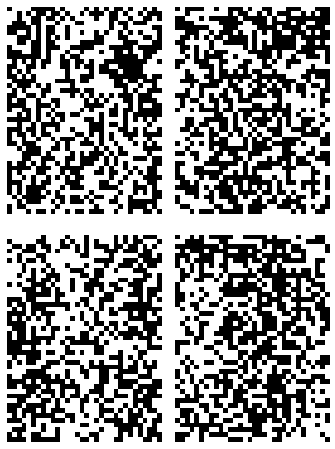

In [318]:
fig, ax = plt.subplots(2,2, figsize = (6,8))
im1 = ax[0,0].imshow(catdogTrain[0,:,:,:].astype("int32")); ax[0,0].axis('off');
im2 = ax[1,0].imshow(catdogTrain[8000,:,:,:].astype("int32")); ax[1,0].axis('off')
im3 = ax[0,1].imshow(catdogTrain[16000,:,:,:].astype("int32")); ax[0,1].axis('off')
im4 = ax[1,1].imshow(catdogTrain[24000,:,:,:].astype("int32")); ax[1,1].axis('off')
fig.subplots_adjust(wspace = 0, hspace = 0.1)
#fig.suptitle('augmented non-face-class training images', fontsize=10)
plt.savefig("./paper/cats_noisy.png", dpi=250, transparent=True)

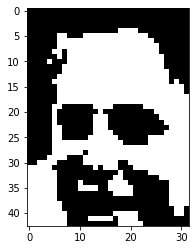

In [289]:
# celeb faces: https://www.kaggle.com/jessicali9530/celeba-dataset?
Nceleb = catdogTrain.shape[0]
celebimages = glob("D:/paredolia/facepareidolia/training/celebs/*.jpg")
celebTrain = np.ndarray((Nceleb,43,32,3))
for j, i in enumerate(celebimages):
    if j >= Nceleb: # catdogimages are the limiting factor
        break
    celebTrain[j,:,:,:] = load_and_preproc(i, crop = True)
plt.imshow(celebTrain[1,:,:,:].astype("int32"))
# for now, i do not augment the celeb database, because we have already enough pictures
celebTrain = render_noisy(celebTrain, p = 0.4)

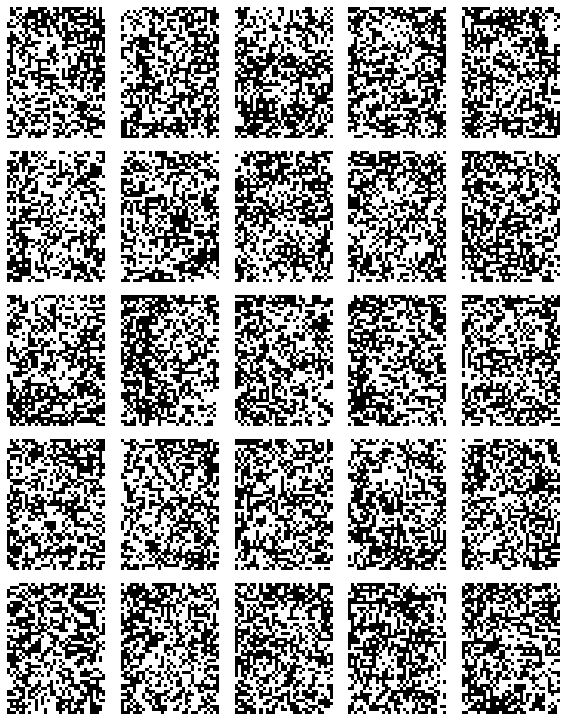

In [317]:
fig, ax = plt.subplots(5,5, figsize=(10,13))
for i in range(5):
    for j in range(5):
        r = np.random.randint(Nceleb)
        im1 = ax[i,j].imshow(celebTrain[r,:,:,:].astype("int32")); ax[i,j].axis('off');
fig.subplots_adjust(wspace = 0.1, hspace = 0.1)
#fig.suptitle('example face-class training images', fontsize=20)
plt.savefig("./paper/celebs_noisy.png", dpi=250, transparent=True)

### Labels & Train Test Split

In [291]:
y = np.repeat((0,1), Nceleb) # labels
cdc = np.concatenate( (catdogTrain, celebTrain), axis = 0 ) # concatenate celebs and cats / dogs
y_binary = to_categorical(y) # one-hot encode labels
X_train, X_test, y_train, y_test = train_test_split(cdc, y_binary, test_size = 0.25, random_state = 42)

### modeling

In [292]:
model = transfer_learning()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # adam #categorical_crossentropy
model.fit(X_train, y_train, epochs=20, batch_size=25)

c:\users\roman\anaconda3\envs\keras-gpu\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
48000/48000 [==============================] - 155s 3ms/step - loss: 0.4867 - acc: 0.7755
Epoch 2/20
48000/48000 [==============================] - 140s 3ms/step - loss: 0.3607 - acc: 0.8476
Epoch 3/20
48000/48000 [==============================] - 142s 3ms/step - loss: 0.3384 - acc: 0.8594
Epoch 4/20
48000/48000 [==============================] - 137s 3ms/step - loss: 0.3204 - acc: 0.8664
Epoch 5/20
48000/48000 [==============================] - 144s 3ms/step - loss: 0.3055 - acc: 0.8743
Epoch 6/20
48000/48000 [==============================] - 144s 3ms/step - loss: 0.2873 - acc: 0.8834
Epoch 7/20
48000/48000 [==============================] - 142s 3ms/step - loss: 0.2725 - acc: 0.8893
Epoch 8/20
48000/48000 [==============================] - 137s 3ms/step - loss: 0.2594 - acc: 0.8980
Epoch 9/20
48000/48000 [==============================] - 138s 3ms/step - loss: 0.2386 - acc: 0.9075
Epoch 10/20
48000/48000 [==============================] - 139s 3ms/step - loss: 0.2235 - a

In [195]:
# to do: train vs test accuracy in a graph --> overfit bla




### benchmarking

The test accuracy of the model with the trained categories is:

In [294]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 85.64%


Are the subjects labels consistent with the model labels?

In [296]:
test_model(model)

Ttest_indResult(statistic=-0.5959179878999177, pvalue=0.5512709717712063)
Ttest_indResult(statistic=0.12884161532993907, pvalue=0.8974907634275303)
Ttest_indResult(statistic=-0.9568775160841951, pvalue=0.33886221380478687)
Ttest_indResult(statistic=1.582166180753353, pvalue=0.11392879274897978)
Ttest_indResult(statistic=0.09631075821180893, pvalue=0.9232932591553852)
Ttest_indResult(statistic=0.28258501518990997, pvalue=0.7775536818377364)
Ttest_indResult(statistic=2.2479921099964644, pvalue=0.02479455203954449)
Ttest_indResult(statistic=-0.9460106164496872, pvalue=0.34437635877078043)
Ttest_indResult(statistic=-0.23091664829533953, pvalue=0.8174279033080671)
Ttest_indResult(statistic=-0.5319452540939276, pvalue=0.5948838658133717)
Ttest_indResult(statistic=-0.8600359888430025, pvalue=0.38997658217600695)
Ttest_indResult(statistic=-0.2371593295575555, pvalue=0.8125819079793499)
across all subjects:
Ttest_indResult(statistic=0.26680757389489307, pvalue=0.7896206468394968)


## reveal "internal templates"

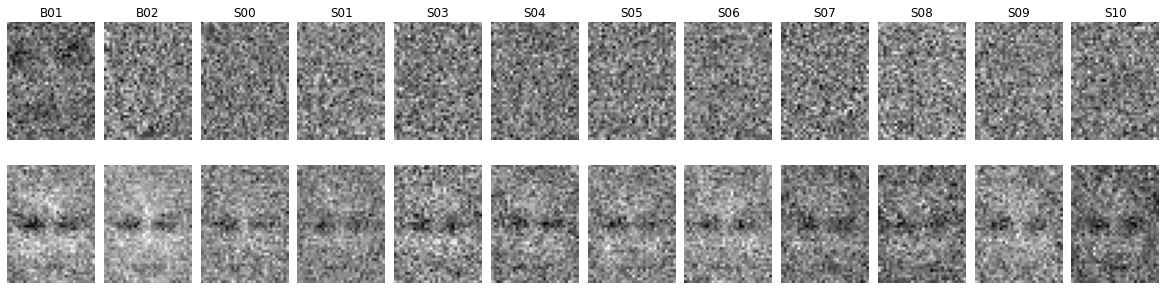

In [335]:
internal_template(model, gauss = 0)
plt.savefig("./paper/template_gauss0.png", dpi=250, transparent = True)

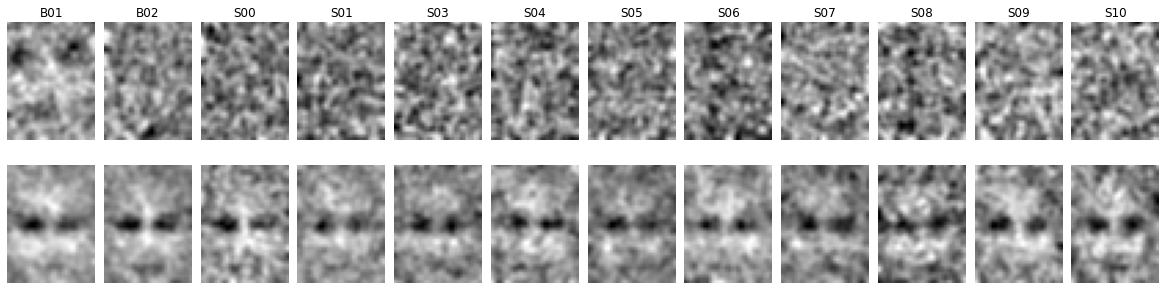

In [336]:
internal_template(model, gauss = 1)
plt.savefig("./paper/template_gauss1.png", dpi=250, transparent = True)

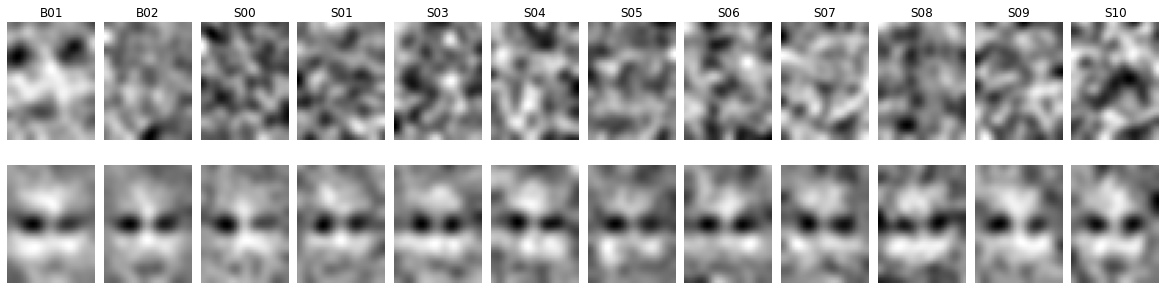

In [337]:
internal_template(model, gauss = 2)
plt.savefig("./paper/template_gauss2.png", dpi=250, transparent = True)

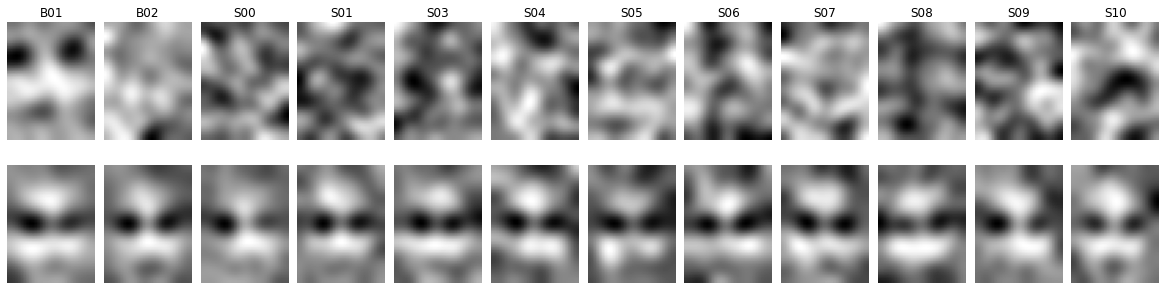

In [338]:
internal_template(model, gauss = 3)
plt.savefig("./paper/template_gauss3.png", dpi=250, transparent = True)

# "hyperparameter" optimization (yes, they are no hyperparameters by definition)

## smooth noise images with 1,3
(cv2 can not smooth with even numbers (i.e. 2)

In [300]:
test_model(model, sigma = 1)

Ttest_indResult(statistic=-0.5959179878999177, pvalue=0.5512709717712063)
Ttest_indResult(statistic=0.12884161532993907, pvalue=0.8974907634275303)
Ttest_indResult(statistic=-0.9568775160841951, pvalue=0.33886221380478687)
Ttest_indResult(statistic=1.582166180753353, pvalue=0.11392879274897978)
Ttest_indResult(statistic=0.09631075821180893, pvalue=0.9232932591553852)
Ttest_indResult(statistic=0.28258501518990997, pvalue=0.7775536818377364)
Ttest_indResult(statistic=2.2479921099964644, pvalue=0.02479455203954449)
Ttest_indResult(statistic=-0.9460106164496872, pvalue=0.34437635877078043)
Ttest_indResult(statistic=-0.23091664829533953, pvalue=0.8174279033080671)
Ttest_indResult(statistic=-0.5319452540939276, pvalue=0.5948838658133717)
Ttest_indResult(statistic=-0.8600359888430025, pvalue=0.38997658217600695)
Ttest_indResult(statistic=-0.2371593295575555, pvalue=0.8125819079793499)
across all subjects:
Ttest_indResult(statistic=-0.024116490319265355, pvalue=0.9807599805425202)


In [301]:
test_model(model, sigma = 3)

Ttest_indResult(statistic=-1.326195187021641, pvalue=0.1848670268231368)
Ttest_indResult(statistic=0.2847738631973325, pvalue=0.7758351217332351)
Ttest_indResult(statistic=0.6223408193744422, pvalue=0.5338608035856633)
Ttest_indResult(statistic=-0.05735090198713125, pvalue=0.9542771647734881)
Ttest_indResult(statistic=0.3768173586477837, pvalue=0.7063900899834914)
Ttest_indResult(statistic=1.0224558816142482, pvalue=0.3068134551830392)
Ttest_indResult(statistic=2.073864627448802, pvalue=0.038348140562878344)
Ttest_indResult(statistic=-0.8525670415384468, pvalue=0.3941077543491939)
Ttest_indResult(statistic=-0.12287451674522414, pvalue=0.9022317362713003)
Ttest_indResult(statistic=-0.9231188631611934, pvalue=0.35617132952888275)
Ttest_indResult(statistic=-0.5567385912436361, pvalue=0.5778313670752604)
Ttest_indResult(statistic=-0.8910374191076209, pvalue=0.3731240706455391)
across all subjects:
Ttest_indResult(statistic=-0.714529605671173, pvalue=0.4749098344784666)


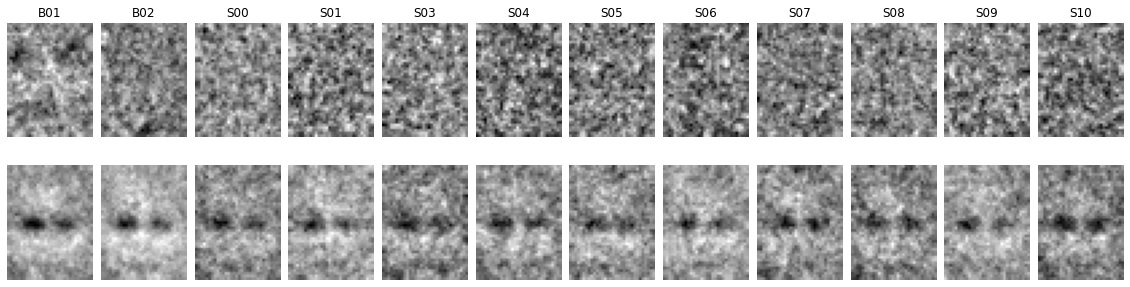

In [302]:
internal_template(model, gauss = 0, sigma = 3)

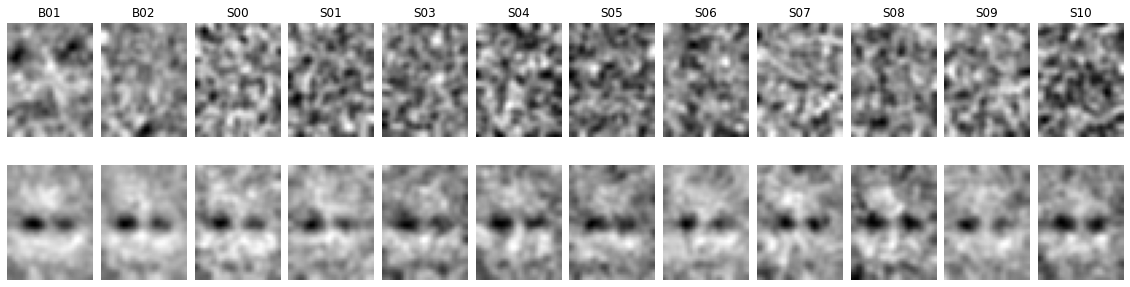

In [303]:
internal_template(model, gauss = 1, sigma = 3)

In [304]:
preds, labs = compare_prediction_similarities(model, sigma = 1)

subject B01
subject B02
subject S00
subject S01
subject S03
subject S04
subject S05
subject S06
subject S07
subject S08
subject S09
subject S10


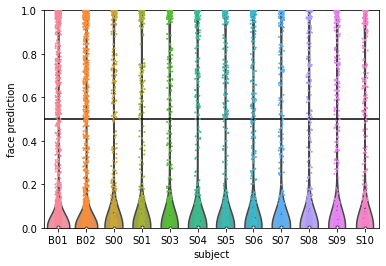

In [344]:
subs = glob("D:/paredolia/facepareidolia/stimuli/*")
subs = [os.path.split(subs[i])[1] for i,s in enumerate(subs)]

# to tidy df
d = []
sub = []
lab = []
for s, i in enumerate(preds):
    l = labs[s]
    for j,k in zip (i,l):
        d.append(j)
        sub.append(subs[s])
        lab.append(k)
di = {"subject":sub,"face prediction":d,"label":lab}

df = pd.DataFrame(di)
df.head()

sns.stripplot(x="subject", y = "face prediction", data = df, size=2)
#sns.violinplot(x="subject", y = "face prediction", data = df)
#plt.yscale('logit') #log
#plt.yscale('log') #log
sns.violinplot(x="subject", y = "face prediction", data = df)
plt.axhline(y=0.5, color = "black")
plt.ylim(0,1)
#plt.show()
plt.savefig("./paper/face_predictions.png", dpi=250, transparency = True)

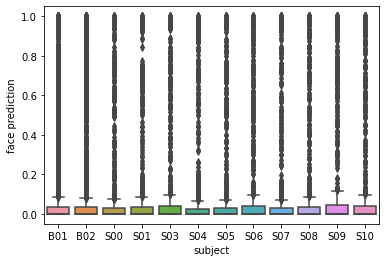

In [341]:
sns.boxplot(x="subject", y = "face prediction", data = df)


In [306]:
df.head()

,subject,face prediction,label
0,B01,9.973300e-01,1
1,B01,6.762539e-05,1
2,B01,5.096979e-03,1
3,B01,6.458542e-12,1
4,B01,3.686646e-02,0


In [307]:
df2 = pd.get_dummies(df.subject, prefix='subject')
df2["label"] = df["label"]
df2["constant"] = 1
df2.head()

,subject_B01,subject_B02,subject_S00,subject_S01,subject_S03,subject_S04,subject_S05,subject_S06,subject_S07,subject_S08,subject_S09,subject_S10,label,constant
0,1,0,0,0,0,0,0,0,0,0,0,0,1,1
1,1,0,0,0,0,0,0,0,0,0,0,0,1,1
2,1,0,0,0,0,0,0,0,0,0,0,0,1,1
3,1,0,0,0,0,0,0,0,0,0,0,0,1,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [308]:
from sklearn import linear_model


In [309]:
reg = linear_model.LinearRegression().fit(df2, df["face prediction"])

In [310]:
reg.coef_

array([-7.92839524e+11, -7.92839524e+11, -7.92839524e+11, -7.92839524e+11,
       -7.92839524e+11, -7.92839524e+11, -7.92839524e+11, -7.92839524e+11,
       -7.92839524e+11, -7.92839524e+11, -7.92839524e+11, -7.92839524e+11,
       -5.99862160e-04,  0.00000000e+00])

In [311]:
reg.intercept_

792839524121.4019

In [312]:
import statsmodels.api as sm
from scipy import stats

In [313]:
est = sm.OLS(df["face prediction"], df2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        face prediction   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5262
Date:                Wed, 08 Jul 2020   Prob (F-statistic):              0.899
Time:                        12:16:07   Log-Likelihood:                -2330.4
No. Observations:               16549   AIC:                             4687.
Df Residuals:                   16536   BIC:                             4787.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
subject_B01     0.0086      0.005      1.728      

## save the model to a file for later usage / reproducibility

In [323]:
model.save('./model_20200707_noisy_p4_20epochs')

## visualize model

In [223]:
#os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model.layers[0], to_file='mobilenet_plot.png', show_shapes=True, show_layer_names=True)